    (array([0.59868766, 0.04459026, 0.04459026, 0.04459026, 0.04459026,
        0.04459026, 0.04459026, 0.04459026, 0.04459026, 0.04459026]),
     array([0.4291727, 0.4291727, 0.4291727, 0.4291727, 0.4291727, 0.4291727,
        0.4291727, 0.4291727, 0.4291727, 0.4291727]))
        
    38626.173 /  0.467 /  9.179 /  0.599 /  0.429 / 122301.308: 100%|██████████| 5000/5000 [17:18<00:00,  4.82it/s]


    Total Unseen: 88390 / Likelihood: -20163.0111


    Total Unseen: 88000 / Likelihood: -20162.9154

In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7201 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [50]:
import pickle
with open('data/gch-10000-20-0.25-5.00.pkl', 'rb') as f:
  GCH, TH = pickle.load(f)
S = 20
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(1317, int)

In [51]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [52]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [53]:
def get_Risq(a,b):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S
    n = tt.constant(np.clip(d,a_min=0,a_max=S+1))
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=max(tmp_u))) # V x S x S
   
    
    # The beta binomial
    R_isq =   tt.gammaln(n+1) # nbn add +1 otherwise
    R_isq -=  tt.gammaln(expanded_u +1)  # nbn add +1 otherwise
    R_isq -=  tt.gammaln(n_u+1)   
    R_isq +=  tt.gammaln(expanded_u+a)
    R_isq +=  tt.gammaln(n_u+b)
    R_isq -=  tt.gammaln(n+a+b)
    R_isq +=  tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)

    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [54]:
def get_Risq0(a,b):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    return tt.exp(R0_sq)

In [55]:
def logp_capture(arr, phi, a, b, U):
    def ll_capture_f(mycaptures):
        
        # Masks: try to compute these once.
        phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
        i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
        R_isq = get_Risq(a, b) #
        R0_sq = get_Risq0(a, b) #
        
        # Likelihood of Capture Li
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        LD = arr[:, np.newaxis] * phi_v * phi
        LD_isq = tt.mul(LD, i_mask)
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2)
        
        # Likelihood of No-Capture L0
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask)
        L0 = tt.sum(LD0 * R0_sq)
        
        # Multinomial
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li))
        obj3 = U * tt.log(L0)

        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [101]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.Uniform('missing', lower=V, upper=100*V)
    a = pm.Uniform('alpha', .01, .1)
    b = pm.Uniform('beta', 1., 10.)
    phi    = pm.Uniform('departure', 0.1, 1., shape=S)
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    #U_print = tt.printing.Print('Unseen')(U)
    #a_print = tt.printing.Print('alpha')(a)
    #b_print = tt.printing.Print('beta')(b)
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U), observed=npdata)
    #step = pm.Metropolis()
    
    #pm.sample(10, step, tune=0, chains=1, progressbar=False)
    #stu = pm.find_MAP()

logp = -1,191.8, ||grad|| = 1.9621e+07: 100%|██████████| 63/63 [00:06<00:00, 10.05it/s]  


In [102]:
stu

{'missing_interval__': array(-5.15986308),
 'alpha_interval__': array(0.24605937),
 'beta_interval__': array(-11.05747326),
 'departure_interval__': array([-61.38033789, -76.32600473, -81.65352697, -83.50063782,
        -83.64627652, -82.37081579, -80.08828672, -77.75501965,
        -75.86787859, -72.46876078, -68.44100078, -64.80485739,
        -67.37000464, -69.30325057, -72.30309981, -72.79060033,
        -66.93785115, -60.92497846, -58.47503511, 124.00900078]),
 'arrival_stickbreaking__': array([ 28.57010269, -14.56018341, -14.64650663, -15.80686729,
        -14.22750643, -10.93132094,  -6.21257418,  -2.31681841,
          7.72546223,  12.5243323 ,  23.58693272,  25.22422409,
         28.34265743,  34.9684186 ,  39.76560235,  45.31634605,
         49.76010985,  44.24506511,  32.91730514]),
 'missing': array(2061.44755961),
 'alpha': array(0.06050857),
 'beta': array(1.00014192),
 'departure': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 

In [ ]:
with model:
  step = pm.NUTS()
  posterior = pm.sample(10000, chains = 1, step = step, cores = 1)

Sequential sampling (1 chains in 1 job)
NUTS: [arrival, departure, beta, alpha, missing]
 22%|██▏       | 2324/10500 [34:24<2:01:01,  1.13it/s]

In [ ]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

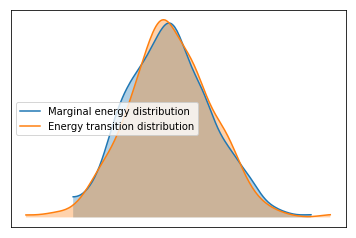

In [81]:
pm.energyplot(posterior);

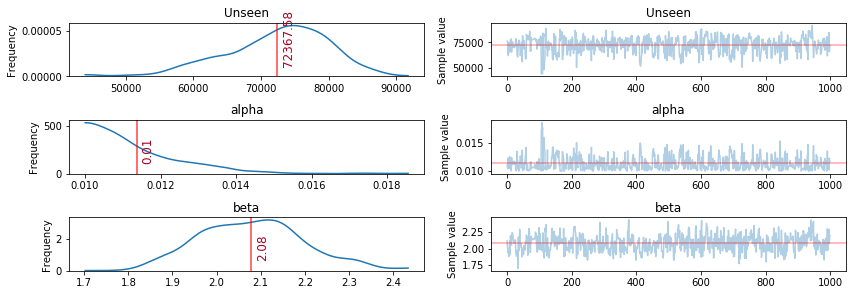

In [97]:
plot_traces(posterior[:], varnames=['Unseen', 'alpha', 'beta']);

In [83]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Unseen,72367.58,7522.81,401.37,56912.25,84885.14
alpha,0.01,0.00,0.00,0.01,0.01
beta,2.08,0.12,0.01,1.88,2.33
departure__0,0.10,0.00,0.00,0.10,0.11
departure__1,0.10,0.00,0.00,0.10,0.11
departure__2,0.10,0.00,0.00,0.10,0.11
departure__3,0.10,0.00,0.00,0.10,0.11
departure__4,0.10,0.00,0.00,0.10,0.11
departure__5,0.10,0.00,0.00,0.10,0.11
departure__6,0.10,0.00,0.00,0.10,0.11


## Let's look at the likelihood values!

In [99]:
#birth_init, dep = (np.array([0.4       , 0.06666667, 0.06666667, 0.06666667, 0.06666667,
#          0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667]),
# np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1. ]))
birth_init, dep = posterior['arrival'].mean(axis = 0).round(2), posterior['departure'].mean(axis = 0).round(2)
for UU in range(5000, 72367 +8000, 1000):
    print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, posterior['alpha'].mean(),  posterior['beta'].mean(), UU)(npdata).eval().round(4))

print("true params")
birth_init = np.concatenate(([.4], np.ones(S-1) * (1-.4)/(S-1)), axis=0)
dep = np.concatenate((np.ones(S-1) * .2, [1.]), axis=0)
for UU in range(5883, 14883, 1000):
    print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, 0.25,  5., UU)(npdata).eval().round(4))
print("Total Unseen:", UU, "/ Likelihood:", logp_capture(birth_init, dep, 0.006,  1., 2061)(npdata).eval().round(4))

Total Unseen: 5000 / Likelihood: -5030.1836
Total Unseen: 6000 / Likelihood: -4853.6058
Total Unseen: 7000 / Likelihood: -4707.3796
Total Unseen: 8000 / Likelihood: -4583.9737
Total Unseen: 9000 / Likelihood: -4478.3451
Total Unseen: 10000 / Likelihood: -4386.9861
Total Unseen: 11000 / Likelihood: -4307.3067
Total Unseen: 12000 / Likelihood: -4237.3852
Total Unseen: 13000 / Likelihood: -4175.7293
Total Unseen: 14000 / Likelihood: -4121.1749
Total Unseen: 15000 / Likelihood: -4072.7768
Total Unseen: 16000 / Likelihood: -4029.7616
Total Unseen: 17000 / Likelihood: -3991.5119
Total Unseen: 18000 / Likelihood: -3957.5122
Total Unseen: 19000 / Likelihood: -3927.2782
Total Unseen: 20000 / Likelihood: -3900.4817
Total Unseen: 21000 / Likelihood: -3876.7633
Total Unseen: 22000 / Likelihood: -3855.8574
Total Unseen: 23000 / Likelihood: -3837.5296
Total Unseen: 24000 / Likelihood: -3821.5612
Total Unseen: 25000 / Likelihood: -3807.7646
Total Unseen: 26000 / Likelihood: -3795.9681
Total Unseen: 2

In [89]:
posterior['beta'].mean()

2.078711689352858

In [100]:
print("Total Unseen:", 2061, "/ Likelihood:", logp_capture(birth_init, dep, 0.006,  1., 2061)(npdata).eval().round(4))

Total Unseen: 2061 / Likelihood: -7248.1469
